### See https://github.com/aleju/imgaug and http://imgaug.readthedocs.io/en/latest/index.html

In [40]:
import imgaug
from imgaug import augmenters as iaa
import numpy as np
import glob
import imageio
import os

In [10]:
input_directory = '/data/dkpun-data/augmentor/input'
image_file_list = glob.glob("{}/images/*.png".format(input_directory))
mask_file_list = glob.glob("{}/masks/*.png".format(input_directory))

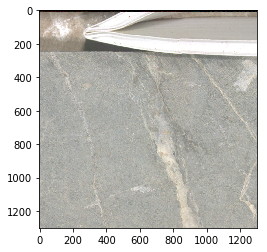

In [21]:
import matplotlib.pyplot as plt
image = imageio.imread('/data/augmented-vein-data/8-jun/images/NC548_0239_00_inst_0_seg_1_orig.png')
_ = plt.imshow(image)

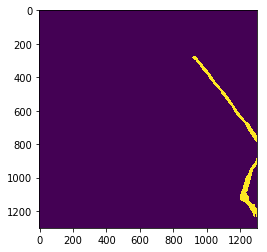

In [22]:
image = imageio.imread('/data/augmented-vein-data/8-jun/masks/NC548_0239_00_inst_0_seg_1_orig.png')
_ = plt.imshow(image)

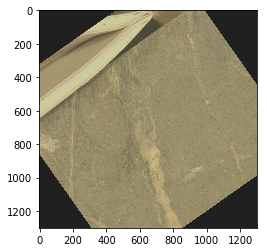

In [25]:
import matplotlib.pyplot as plt
image = imageio.imread('/data/augmented-vein-data/8-jun/images/NC548_0239_00_inst_0_seg_1_augm_0.png')
_ = plt.imshow(image)

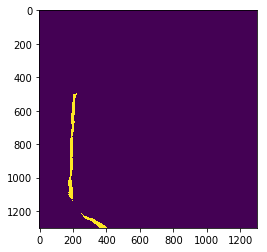

In [26]:
import matplotlib.pyplot as plt
image = imageio.imread('/data/augmented-vein-data/8-jun/masks/NC548_0239_00_inst_0_seg_1_augm_0.png')
_ = plt.imshow(image)

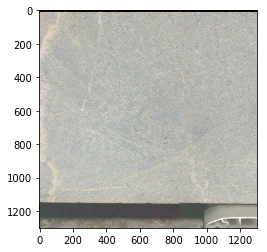

In [31]:
image = imageio.imread('/data/augmented-vein-data/8-jun/images/NC548_0239_03_inst_3_seg_1_orig.png')
_ = plt.imshow(image)

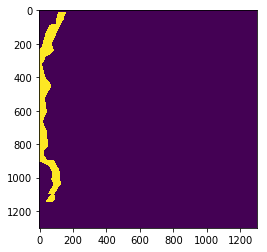

In [32]:
image = imageio.imread('/data/augmented-vein-data/8-jun/masks/NC548_0239_03_inst_3_seg_1_orig.png')
_ = plt.imshow(image)

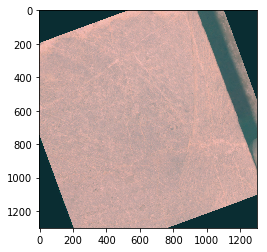

In [33]:
image = imageio.imread('/data/augmented-vein-data/8-jun/images/NC548_0239_03_inst_3_seg_1_augm_0.png')
_ = plt.imshow(image)

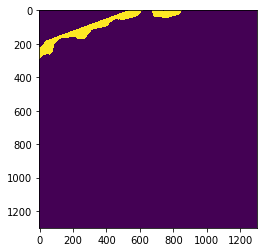

In [34]:
image = imageio.imread('/data/augmented-vein-data/8-jun/masks/NC548_0239_03_inst_3_seg_1_augm_0.png')
_ = plt.imshow(image)

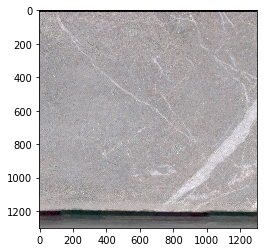

In [35]:
image = imageio.imread('/data/augmented-vein-data/8-jun/images/UE118_0092_00_inst_1_seg_9_orig.png')
_ = plt.imshow(image)

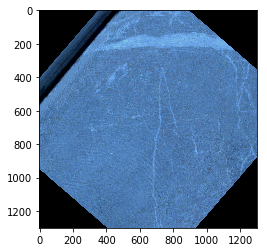

In [36]:
image = imageio.imread('/data/augmented-vein-data/8-jun/images/UE118_0092_00_inst_1_seg_9_augm_0.png')
_ = plt.imshow(image)

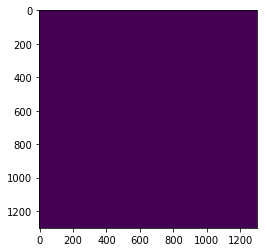

In [37]:
image = imageio.imread('/data/augmented-vein-data/8-jun/masks/UE118_0092_00_inst_1_seg_9_augm_0.png')
_ = plt.imshow(image)

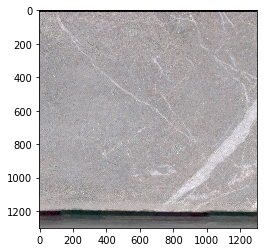

In [38]:
image = imageio.imread('/data/augmented-vein-data/8-jun/images/UE118_0092_00_inst_1_seg_9_orig.png')
_ = plt.imshow(image)

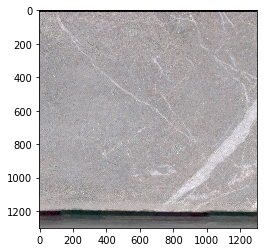

In [43]:
image = imageio.imread('/data/augmented-vein-data/8-jun/images/UE118_0092_00_inst_1_seg_9_orig.png')
_ = plt.imshow(image)

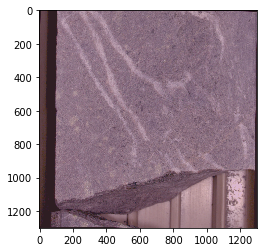

In [54]:
image = imageio.imread('/data/augmented-vein-data/8-jun-20-1/images/UE219_0115_03_inst_8_seg_5_augm_6.png')
_ = plt.imshow(image)

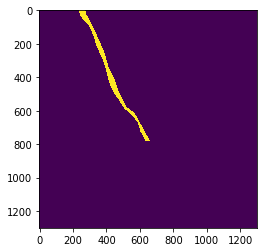

In [56]:
image = imageio.imread('/data/augmented-vein-data/8-jun-20-1/masks/UE219_0115_03_inst_8_seg_5_augm_6.png')
_ = plt.imshow(image)